# Inspect TERN data

    Author: Ben Ross
    Approximate date: 16 June 2020

Description: Inspect TERN data (fractional cover right now) according to defined spring polygons. Then generate band maths/statistics on these polygon/raster combinations.
Detailed explanation: Deans spring polygons are imported as a geodataframe called 'shapes'. We then use these shapes to clip a bunch of rasters to the spring extents. In this case the bunch of rasters is remotely located and would be many hundreds of GB to download normally.

The clipped raster blocks are unique to each spring, I've then calculated some statistics for each band in the raster and output a list for insertion into the dataframe.

Each new column should contain all the statistics for 1x raster at the row/spring location.

Resources:
* Tern data address > https://data.tern.org.au/rs/public/data/
* Rasterio page related to this task > https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

In [2]:
# import modules
import matplotlib.pyplot as plt
#import fiona
import rasterio
import rasterio.mask
import rasterio.plot
import geopandas as gpd
import numpy
from rasterio.plot import show
import pandas

ModuleNotFoundError: No module named 'rasterio'

## Define inputs

Here we are declaring the input geometry. This is only one polygon at the moment so we can clearly see the data in plots. Gather general information about the input raster. This cell wil be omitted from the final code.

In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

# html_path = "https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/"
html_path = "https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/"
html = urlopen(html_path)
bsObj = BeautifulSoup(html.read());

url_list=[]
for link in bsObj.find_all('a'):
    url_list.append(html_path+str(link.get('href')))
url_list = url_list[1:]

In [4]:
url_list

['https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/cvmsre_qld_m201512201602_acaa2.tif',
 'https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/cvmsre_qld_m201603201605_acaa2.tif',
 'https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/cvmsre_qld_m201606201608_acaa2.tif',
 'https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/cvmsre_qld_m201609201611_acaa2.tif',
 'https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/cvmsre_qld_m201612201702_acaa2.tif',
 'https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/cvmsre_qld_m201703201705_acaa2.tif',
 'https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/cvmsre_qld_m201706201708_acaa2.tif',
 'https://data.tern.org.au/rs/public/data/sentin

In [1]:
# plot geometry attributes as a geodataframe to just be sure that everything looks okay
geometry = r'C:\Users\rossb1\DATA\script_inputs\raster-data-collection\unique.geojson'
shapes = gpd.read_file(geometry)
shapes.head()
print('Coordinate reference system for geojson {crs}'.format(crs = shapes.crs))

# generate a list of rasters addresses from interpreting the remote TERN server
from urllib.request import urlopen
from bs4 import BeautifulSoup

# html_path = "https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/"
html_path = "https://data.tern.org.au/rs/public/data/sentinel2/seasonal_fractional_cover/fractional_cover/qld/"
html = urlopen(html_path)
bsObj = BeautifulSoup(html.read());

url_list=[]
for link in bsObj.find_all('a'):
    url_list.append(html_path+str(link.get('href')))
url_list = url_list[1:]


'''rgb = 'https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m198712198802_dima2.tif'
src = rasterio.open(rgb)
print(src)

# generate information about the opened raster if needed
num_bands = rasterio.open(rgb).count
print('Number of bands in image: {n}\n'.format(n=num_bands))
print(rasterio.open(rgb).nodatavals)'''

NameError: name 'gpd' is not defined

## Perform the intersection

Now that we have a handle on the shape of the items we are going to be performing calculations on we can move onto a list operation. From here we are interrogating the remote server hosting the rasters and listing the items. Each item in the list returns a result in approximately 12 seconds on Ben Ross' home network. Average downlink speeds range between 6 & 20mbs.

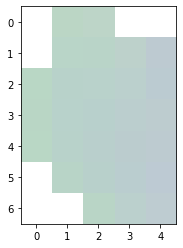 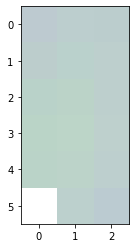
You should expect to see parts of the image look like this. I.e.; Cropped to a spring polygon for all calls that touch the geometry.

In [5]:
# iterate through the url-list and clip rasters to geometry extents and save the result to memory. NOT TO DISK AT THIS STAGE
for url in url_list:
    #try:
    print(url)
    src = rasterio.open(url)
    shapes[url] = ''
    for index, row in shapes.iterrows():
        #print(row['COMPLEX_NA'], row['SITE_NO'])
        # clip the source image to the spring geometry. the result is a tiny image/4band array
        out_image, out_transform = rasterio.mask.mask(src, row.geometry, crop=True, all_touched=True, nodata=0)
        out_meta = src.meta

        # Calculate statistics for each band
        stats = []
        for band in out_image:
            stats.append({
                'min': band.min(),
                'mean': band.mean(),
                'median': numpy.median(band),
                'max': band.max()})

        # for each row/spring polygon, add the stats as a list within column 'url' to the 'shapes' dataframe
        shapes.at[index, url] = stats
        
        # this sometimes throws an error if the feature is too small, omit without worry if needed
        #show(out_image) #this outputs a nice little visualisation of what is happening

    #be sure to close the source raster at the top level. this is memory efficient
    src.close()
    #except:
        #print('Failure. Moving to next url')

#shapes.to_csv (r'C:\Users\rossb1\DATA\script_outputs\raster-data-collection\unique_analysed_ground_cover.csv', header=True)

https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m198912199002_dixa2.tif
https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m199003199005_dixa2.tif
https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m199006199008_dixa2.tif
https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m199009199011_dixa2.tif
https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m199012199102_dixa2.tif
https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m199103199105_dixa2.tif
https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m199106199108_dixa2.tif
https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/ground_cover/qld/lztmre_qld_m199109199111_di

In [14]:
shapes

,OBJECTID,SITE_NO,COMPLEX_NA,Shape_Leng,Shape_Area,geometry,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m198712198802_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m198803198805_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m198806198808_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m198809198811_dima2.tif,...,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201709201711_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201712201802_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201803201805_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201806201808_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201809201811_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201812201902_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201903201905_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201906201908_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201909201911_dima2.tif,https://data.tern.org.au/rs/public/data/landsat/seasonal_fractional_cover/fractional_cover/qld/lztmre_qld_m201912202002_dima2.tif
0,1.0,1,Boggomoss (5),441.053123,6504.471244,"MULTIPOLYGON (((1786054.701 -2877412.451, 1786...","[{'min': 0, 'mean': 99.94444444444444, 'median...","[{'min': 0, 'mean': 97.72222222222223, 'median...","[{'min': 0, 'mean': 98.16666666666667, 'median...","[{'min': 0, 'mean': 101.38888888888889, 'media...",...,"[{'min': 0, 'mean': 97.55555555555556, 'median...","[{'min': 0, 'mean': 99.11111111111111, 'median...","[{'min': 0, 'mean': 95.83333333333333, 'median...","[{'min': 0, 'mean': 98.83333333333333, 'median...","[{'min': 0, 'mean': 97.66666666666667, 'median...","[{'min': 0, 'mean': 100.83333333333333, 'media...","[{'min': 0, 'mean': 96.72222222222223, 'median...","[{'min': 0, 'mean': 97.72222222222223, 'median...","[{'min': 0, 'mean': 101.61111111111111, 'media...","[{'min': 0, 'mean': 101.05555555555556, 'media..."
1,2.0,11,Boggomoss (5),653.316466,7230.021595,"MULTIPOLYGON (((1787562.736 -2879544.462, 1787...","[{'min': 110, 'mean': 111.0, 'median': 111.0, ...","[{'min': 107, 'mean': 107.5, 'median': 107.5, ...","[{'min': 102, 'mean': 103.0, 'median': 103.0, ...","[{'min': 110, 'mean': 110.5, 'median': 110.5, ...",...,"[{'min': 105, 'mean': 105.5, 'median': 105.5, ...","[{'min': 104, 'mean': 104.0, 'median': 104.0, ...","[{'min': 100, 'mean': 100.5, 'median': 100.5, ...","[{'min': 103, 'mean': 103.5, 'median': 103.5, ...","[{'min': 107, 'mean': 108.0, 'median': 108.0, ...","[{'min': 107, 'mean': 107.5, 'median': 107.5, ...","[{'min': 102, 'mean': 102.5, 'median': 102.5, ...","[{'min': 102, 'mean': 103.0, 'median': 103.0, ...","[{'min': 109, 'mean': 109.0, 'median': 109.0, ...","[{'min': 108, 'mean': 108.5, 'median': 108.5, ..."
2,2.0,11,Boggomoss (5),653.316466,7230.021595,"MULTIPOLYGON (((1787613.741 -2879525.767, 1787...","[{'min': 0, 'mean': 86.85, 'median': 108.0, 'm...","[{'min': 0, 'mean': 83.95, 'median': 104.0, 'm...","[{'min': 0, 'mean': 83.5, 'median': 103.5, 'ma...","[{'min': 0, 'mean': 86.95, 'median': 107.0, 'm...",...,"[{'min': 0, 'mean': 84.85, 'median': 106.0, 'm...","[{'min': 0, 'mean': 83.1, 'median': 103.5, 'ma...","[{'min': 0, 'mean': 80.3, 'median': 100.0,

In [9]:
#shapes.to_file(r'C:\Users\rossb1\DATA\scripts\DESIGN_outputs\raster-data-collection\unique_analysed.geojson', driver='GeoJSON')
shapes.to_csv(r'C:\Users\rossb1\DATA\script_outputs\raster-data-collection\unique_analysed_ground_cover.csv', header=True)